In [1]:
# Random Library Imports
import subprocess,os,glob,tempfile,re,webbrowser,io,sys,types,\
time

# Importing Datetime Libraries
from datetime import datetime, timedelta

# CartoPy Map Plotting Libraires
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Proj 

# Numerical and Scientific Libraries
import numpy as np
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter

# Accessing Data from External Databases via XLM Catalog
from siphon.ncss import NCSS
from siphon.catalog import TDSCatalog

# MetPy Libraries
import metpy
import metpy.calc as mpcalc
from metpy.units import masked_array, units
from metpy.plots import ctables
from metpy.plots import add_metpy_logo
from metpy.constants import g

# NetCDF Libraries
from netCDF4 import Dataset
from netCDF4 import num2date

# More Image Manipulation Options
from PIL import Image as PILImage
from IPython.display import Image

# Ipyhton Options
from IPython import get_ipython
from nbformat import current
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import HTML, display, Image

# Matplotlib Plotting Libraries
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.colors import LinearSegmentedColormap



/Users/chowdahead/miniconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/chowdahead/miniconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/Users/chowdahead/miniconda3/lib/python3.7/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


In [2]:
# Set the font 
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 18,
        }

In [3]:
# Thanks to the crew over at Metpy for this handy little function
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)

In [4]:
# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

# Add Map Features
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')

country_borders = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_0_countries',scale='50m', facecolor='none')

# Colorbar Axis Placement (under figure)
colorbar_axis = [0.183, 0.09, 0.659, 0.03] # [left, bottom, width, height]

# Lat/Lon Extents [lon0,lon1,lat0,lat1]
extent = [-130., -70, 20., 60.]

In [5]:
now = datetime.utcnow()
#now = datetime(2019,2,7,18,0)
today_day = int('{0:%d}'.format(now))
today_year = int('{0:%Y}'.format(now))
today_month = int('{0:%m}'.format(now))
print(today_day,today_year,today_month)

forecast_times = []
#forecast_times.append(now)
for i in range(4,8):
    forecast_times.append(datetime(today_year,today_month,today_day,i*3,0))
for i in range(0,8):
    forecast_times.append(datetime(today_year,today_month,today_day+1,i*3,0))
for i in range(0,5):
    forecast_times.append(datetime(today_year,today_month,today_day+2,i*3,0))
forecast_times

12 2019 4


[datetime.datetime(2019, 4, 12, 12, 0),
 datetime.datetime(2019, 4, 12, 15, 0),
 datetime.datetime(2019, 4, 12, 18, 0),
 datetime.datetime(2019, 4, 12, 21, 0),
 datetime.datetime(2019, 4, 13, 0, 0),
 datetime.datetime(2019, 4, 13, 3, 0),
 datetime.datetime(2019, 4, 13, 6, 0),
 datetime.datetime(2019, 4, 13, 9, 0),
 datetime.datetime(2019, 4, 13, 12, 0),
 datetime.datetime(2019, 4, 13, 15, 0),
 datetime.datetime(2019, 4, 13, 18, 0),
 datetime.datetime(2019, 4, 13, 21, 0),
 datetime.datetime(2019, 4, 14, 0, 0),
 datetime.datetime(2019, 4, 14, 3, 0),
 datetime.datetime(2019, 4, 14, 6, 0),
 datetime.datetime(2019, 4, 14, 9, 0),
 datetime.datetime(2019, 4, 14, 12, 0)]

In [6]:
# Set a path to save the plots with string format for the date to set the month and day 
im_save_path ="/path/to/saved/images/"
im_save_path = "/Users/ChowdaHead/Desktop/Weather_Blog/"
print(im_save_path)

# Check to see if the folder already exists, if not create it
if not os.path.isdir(im_save_path):
    os.makedirs(im_save_path)

# Uncomment if you want to automatically change to the map folder    
#os.chdir(im_save_path)

/Users/ChowdaHead/Desktop/Weather_Blog/


In [7]:
from siphon.catalog import TDSCatalog
top_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
ref = top_cat.catalog_refs['Observation Data']
new_cat = ref.follow()
new_cat

THREDDS-IDD OPeNDAP Data Server - Station Data

In [9]:
model = new_cat.catalog_refs[0]
gfs_cat = model.follow()
ds = gfs_cat.datasets[0]

In [10]:

print("Variable Name:",ds.name)
print("Path:",ds.url_path)

Variable Name: Feature Collection
Path: nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr


In [11]:
ds = gfs_cat.datasets[0]
subset = ds.subset()
query_data = subset.query()

In [12]:

query_data.lonlat_box(west=-130, east=-50, south=10, north=60)

# Allow for NetCDF files
query_data.accept('netcdf4')
query_data.time(now)
data = query_data.variables('air_temperature')

# Finally attempt to access the data
data = subset.get_data(query_data)

In [15]:
list(data.variables)
    

['latitude',
 'longitude',
 'stationAltitude',
 'station_id',
 'station_description',
 'wmo_id',
 'time',
 'stationIndex',
 'air_temperature']

In [84]:
ass = data.variables['stationIndex']
ass2 = data.variables['station_id'][:]
list(data.variables['station_description'][0:10])

[masked_array(data=[b'S', b'A', b'G', b'U', b'A', b'C', b'H', b'E', b' ',
                    b'M', b'U', b'N', b'I', b',', b' ', b'C', b'O', b' ',
                    b'U', b'S', b'', b'', b'', b'', b'', b'', b'', b'',
                    b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b''],
              mask=False,
        fill_value=b'N/A',
             dtype='|S1'),
 masked_array(data=[b'C', b'H', b'A', b'R', b'L', b'O', b'T', b'T', b'E',
                    b'/', b'F', b'I', b'T', b'C', b'H', b' ', b'H', b' ',
                    b'B', b'E', b'A', b'C', b'H', b',', b' ', b'M', b'I',
                    b' ', b'U', b'S', b'', b'', b'', b'', b'', b'', b'',
                    b'', b''],
              mask=False,
        fill_value=b'N/A',
             dtype='|S1'),
 masked_array(data=[b'B', b'E', b'R', b'T', b'H', b'O', b'U', b'D', b' ',
                    b'P', b'A', b'S', b'S', b',', b' ', b'C', b'O', b' ',
                    b'U', b'S', b'', b'', b'', b'', b'', b'', b'', b''

In [101]:
name = str(data.variables['station_description'][0][0])
name = name[2]
name

'S'

In [63]:
data.variables['wmo_id'][0]

masked_array(data=[b'9', b'9', b'9', b'9', b'9', b''],
             mask=False,
       fill_value=b'N/A',
            dtype='|S1')

In [75]:
lat = data.variables['latitude'][:]
lon = data.variables['longitude'][:]
temp = data.variables['air_temperature'][:]

In [76]:
lat.shape,lon.shape

((2698,), (2698,))

In [77]:
temp.shape

(1498,)

In [57]:
data.variables['time']

<class 'netCDF4._netCDF4.Variable'>
float64 time(obs)
    units: seconds since 1970-01-01
    long_name: time of measurement
unlimited dimensions: obs
current shape = (1498,)
filling off

In [53]:
temp[200]

masked_array(data=2.6,
             mask=False,
       fill_value=1e+20,
            dtype=float32)

[dat_ti_e._atZ


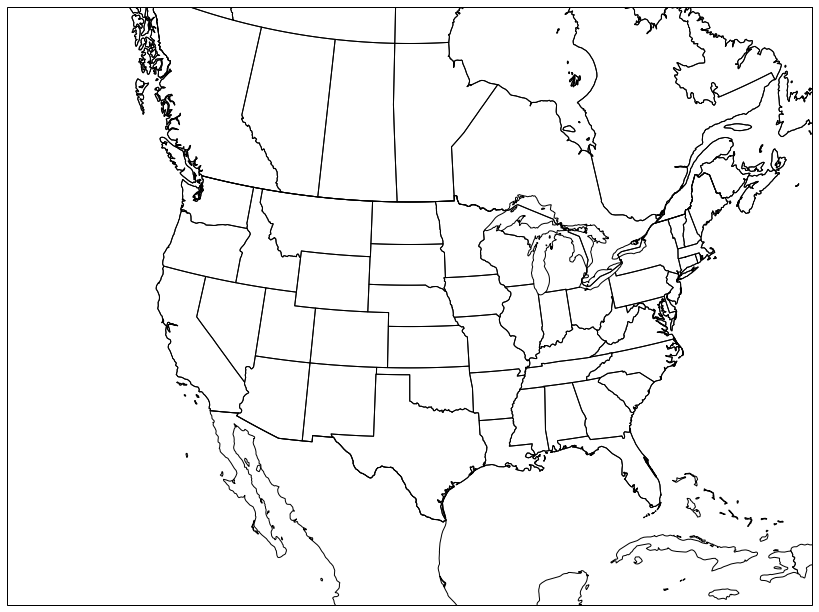

In [79]:

    
    # Create a figure object, title it, and do the plots.
fig = plt.figure(figsize = (17.,11.))

add_metpy_logo(fig, 30, 940, size='small')

# Add the map and set the extent
ax5 = plt.subplot(1,1,1, projection=plotcrs)
ax5.set_extent(extent, datacrs)

# Add state boundaries to plot
ax5.add_feature(states_provinces, edgecolor='k', linewidth=1)

# Add country borders to plot
ax5.add_feature(country_borders, edgecolor='black', linewidth=1)

# Convert number of hours since the reference time into an actual date
time_var = data.variables['time']
time_final = num2date(time_var[:].squeeze(), time_var.units)
print(str(time_final)[:4]+"_"+str(time_final)[5:7]+"_"+str(time_final)[8:10]+"_"+str(time_final)[11:13]+"Z")
file_time = str(time_final)[:4]+"_"+str(time_final)[5:7]+"_"+str(time_final)[8:10]+"_"+str(time_final)[11:13]+"Z"
    
# Plot Title
#plt.title('GFS: 1000 and 500mb Heights (m)',loc='left',fontdict=font)
#plt.title(' {0:%d %B %Y %H:%MZ}'.format(time_final),loc='right',fontdict=font)

                                        # 
#---------------------------------------------------------------------------------------------------


#cs = ax5.contour(lon, lat, temp[:], colors='blue', linewidths=2.0,
#                linestyles='solid', transform=ccrs.PlateCarree())



plt.show()